In [2]:
# install on first run
# python -m venv .venv,,
# pip install -r requirements

from dotenv import load_dotenv

from langchain_community.llms import HuggingFaceEndpoint
from langchain_core.prompts import PromptTemplate

from typing import List
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.output_parsers import JsonOutputParser

from readability import Readability
from readability.exceptions import ReadabilityException

load_dotenv()

True

### Model and Chain

In [4]:
# hub = HuggingFaceEndpoint(repo_id="NousResearch/Nous-Hermes-2-Mixtral-8x7B-DPO")
hub = HuggingFaceEndpoint(repo_id="mistralai/Mistral-7B-Instruct-v0.2")

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to C:\Users\alanj\.cache\huggingface\token
Login successful


In [6]:
tasks_template = """<|im_start|>system
As a seasoned game designer with expertise in creating engaging educational content for children, 
I challenge you to craft a JSON list of 10 captivating game scene tasks and prompts that will help children with autism master what they are learning.
Please present each task and prompt as a JSON list item, with a clear description that will motivate and engage young learners. 
Your tasks should be designed to gradually increase in difficulty, with a mix of fun and challenging activities that cater to different learning styles.
A childs reading level is a measure of how easy a text is to read. It is usually measured in years, so a reading level of 5 means that a 5 year old can read it. 
If a child is struggling with reading, they may have a reading level that is lower than their actual age.<|im_end|>
<|im_start|>user
{name} is {age} years old and has a reading level age of {reading_level}. They need help with learning {teaching_task}.

Please make a list of 10 suitable game scene tasks and prompts to learn {teaching_task}.

Just list out each item 1 by 1 in a JSON list. Do not include the question or any other information, just the list in JSON.<|im_end|>
<|im_start|>assistant
Here is a JSON list of 10 game scene tasks and prompts to help {name} with learning {teaching_task}:
"""

class Tasks(BaseModel):
    tasks: List = Field(description="list of game scene tasks")


parser = JsonOutputParser(pydantic_object=Tasks)

tasks_prompt_json = PromptTemplate(
    template=tasks_template,
    input_variables=["name", "age", "reading_level", "teaching_task"],
    partial_variables={"format_instructions": parser.get_format_instructions()},
)

tasks_chain = tasks_prompt_json | hub | parser

### Wrappers

In [8]:
def spache_wrapper(rd: Readability):
    try:
        return rd.spache().score
    except ReadabilityException:
        return -1

def flesch_wrapper(rd: Readability):
    try:
        return rd.flesch().score
    except ReadabilityException:
        return -1

def flesch_kincaid_wrapper(rd: Readability):
    try:
        return rd.flesch_kincaid().score
    except ReadabilityException:
        return -1


def ari_wrapper(rd: Readability):
    try:
        return rd.ari().score
    except ReadabilityException:
        return -1


def coleman_liau_wrapper(rd: Readability):
    try:
        return rd.coleman_liau().score
    except ReadabilityException:
        return -1


def dale_chall_wrapper(rd: Readability):
    try:
        return rd.dale_chall().score
    except ReadabilityException:
        return -1


def gunning_fog_wrapper(rd: Readability):
    try:
        return rd.gunning_fog().score
    except ReadabilityException:
        return -1


def linsear_write_wrapper(rd: Readability):
    try:
        return rd.linsear_write().score
    except ReadabilityException:
        return -1


def smog_wrapper(rd: Readability):
    try:
        return rd.smog(all_sentences=True).score
    except ReadabilityException:
        return -1

def statistics_wrapper(rd: Readability):
    try:
        return rd.statistics()
    except ReadabilityException:
        return -1

## Prompts

In [9]:
teaching_tasks = [
    "How to get ready for school",
    "How to identify shapes",
    "How to read body language",
    "How to understand facial expressions",
    "How to share with others",
    "How to empathise with others",
    "How to handle identify emotions",
    "How to deal with emotions",
    "How to spell their name",
    "How to solve a maze",
    "How to tidy up",
    "How to ask for help",
    "How to brush teeth",
    "How to use the toilet",
    "How to deal with loud noises",
    "How to deal with bright lights",
    "How to deal with strong smells",
    "How to make friends",
    "How to help others",
]

## Evaluation

In [10]:
input_params = [
    "name", "age", "reading_level", "teaching_task"
]

readability_evaluators = [
    "spache", "flesch", "flesch_kincaid", "ari", "coleman_liau", "dale_chall", "gunning_fog", "linsear_write", "smog"
]

statistics_keys = [
    "num_letters", "num_words", "num_sentences", "num_polysyllabic_words", "avg_words_per_sentence", "avg_syllables_per_word"
]

In [14]:
def evaluate_tasks(llm_input, output_file):
    eval_results = []

    with open(output_file, "a") as f:
        # Write the header
        f.writelines("{0}\tLLM Output\t{1}\t{2}\n".format('\t'.join(input_params), '\t'.join(readability_evaluators), '\t'.join(statistics_keys)))
        
        # Loop through the teach tasks
        for teaching_task in teaching_tasks:

            llm_input["teaching_task"] = teaching_task
            
            try:
                llm_output = tasks_chain.invoke(llm_input)
            except (Exception) as e:
                print(e)
                try:
                    llm_output = tasks_chain.invoke(llm_input)
                except (Exception) as e:
                    print(e)
                    continue

            print(llm_output)

            # Parse the output
            rd = Readability(str(llm_output))

            scores = {
                "spache": spache_wrapper(rd),
                "flesch": flesch_wrapper(rd),
                "flesch_kincaid": flesch_kincaid_wrapper(rd),
                "ari": ari_wrapper(rd),
                "coleman_liau": coleman_liau_wrapper(rd),
                "dale_chall": dale_chall_wrapper(rd),
                "gunning_fog": gunning_fog_wrapper(rd),
                "linsear_write": linsear_write_wrapper(rd),
                "smog": smog_wrapper(rd),
            }
            
            statistics = statistics_wrapper(rd)
            
            input_params_str = "\t".join([str(llm_input[param]) for param in input_params])
            scores_str = "\t".join([str(scores[evaluator]) for evaluator in readability_evaluators])
            statistics_keys_str = "\t".join([str(statistics[key]) for key in statistics_keys])
                
            eval_results.append({
                "llm_input": llm_input,
                "llm_output": llm_output,
                "scores": scores
            })

            f.writelines("{0}\t{1}\t{2}\t{3}\n".format(input_params_str, llm_output, scores_str, statistics_keys_str))
    return eval_results

In [15]:
evaluation_william_results = evaluate_tasks(
    {
        "name": "William",
        "age": 7,
        "reading_level": 5,
    },
    "evaluation_william.tsv"
)

[{'task': 'Dressing Monkey', 'description': 'Help a monkey put on different clothes based on the weather or the day of the week.'}, {'task': 'Pack a Backpack', 'description': 'Pack a backpack with necessary school items like books, pencils, and water bottle.'}, {'task': 'Brush Teeth Animals', 'description': 'Brush teeth of different animals to learn the correct way and make them smile.'}, {'task': 'Match Socks', 'description': 'Match pairs of socks based on colors or patterns.'}, {'task': 'Button Shirt Game', 'description': 'Help a character button a shirt, teaching fine motor skills and counting.'}, {'task': 'Shoelace Tying', 'description': 'Learn to tie shoelaces with a friendly character that provides step-by-step instructions.'}, {'task': 'Make Bed', 'description': 'Help a teddy bear make its bed with blankets and pillows.'}, {'task': 'Set the Table', 'description': 'Set the table for breakfast with different food items and place settings.'}, {'task': 'Find Missing Items', 'descrip

In [16]:
evaluation_sophie_results = evaluate_tasks(
    {
        "name": "Sophie",
        "age": 7,
        "reading_level": 5,
    },
    "evaluation_sophie.tsv"
)

[{'task': 'Find and match socks with the same design.', 'prompt': "Let's find a pair of socks that matches! Look at the designs on these socks and find another one that is the same."}, {'task': 'Sort buttons on a shirt.', 'prompt': 'Help us sort these buttons on the shirt. Put all the red buttons in this bowl and all the blue buttons in that one.'}, {'task': 'Put on a hat.', 'prompt': "Let's wear a hat today! Find the hat in the closet and put it on your head. Can you find a hat that matches your outfit?"}, {'task': 'Put on shoes.', 'prompt': "Let's put on our shoes. Which foot goes in which shoe? Can you tie your shoelaces by yourself?"}, {'task': 'Brush teeth.', 'prompt': "Let's brush our teeth together! Find the toothbrush and toothpaste. Remember to brush for 2 minutes."}, {'task': 'Find and put on a belt.', 'prompt': "Can you find the belt and put it on by yourself? Remember to adjust it so it's comfortable."}, {'task': 'Pack a backpack.', 'prompt': "Let's pack our backpack for sc

In [17]:
evaluation_reading_level_10_results = evaluate_tasks(
    {
        "name": "William",
        "age": 7,
        "reading_level": 10,
    },
    "evaluation_reading_level_10.tsv"
)

[{'task': 'Match Clothes', 'description': 'Match the correct clothes (shirt, pants, socks, shoes) with the weather and school day (Monday, Tuesday, etc.) using a drag-and-drop interface.'}, {'task': 'Brush Teeth', 'description': "Brush the cartoon character's teeth by dragging the toothbrush over their teeth on the screen."}, {'task': 'Make Bed', 'description': 'Make the bed by pulling up the covers and smoothing the pillows.'}, {'task': 'Pack Backpack', 'description': 'Pack a backpack with the correct items (book, pencil, water bottle, etc.) by dragging and dropping.'}, {'task': 'Tie Shoes', 'description': 'Tie virtual shoelaces by following a step-by-step guide on the screen.'}, {'task': 'Find Missing Items', 'description': 'Help find missing school items by looking in various places in the virtual environment.'}, {'task': 'Dress the Doll', 'description': 'Dress a doll by choosing and putting on the correct clothes.'}, {'task': 'Eat Breakfast', 'description': 'Help the character eat 

In [18]:
evaluation_age_10_results = evaluate_tasks(
    {
        "name": "William",
        "age": 10,
        "reading_level": 5,
    },
    "evaluation_age_10.tsv"
)

1
[{'Task': 'Matching Game', 'Description': 'Find and click on shapes that match, displayed in pairs.'}, {'Task': 'Shape Trace', 'Description': 'Trace the outline of each shape using a mouse or finger.'}, {'Task': 'Color Shapes', 'Description': 'Color each shape with the correct color.'}, {'Task': 'Shape Sort', 'Description': 'Sort shapes into different groups based on their type.'}, {'Task': 'Shape Memory', 'Description': 'Memorize a sequence of shapes and recreate it.'}, {'Task': 'Shape Puzzles', 'Description': 'Assemble puzzles of various shapes.'}, {'Task': 'Shape Song', 'Description': 'Sing a song about shapes while identifying them.'}, {'Task': 'Shape Animation', 'Description': 'Watch animations of shapes and identify them.'}, {'Task': 'Shape Storytelling', 'Description': 'Create stories using shapes as characters.'}, {'Task': 'Shape Building', 'Description': 'Build structures using shapes.'}]
[{'task': "Identify Happy Emotions: Look for smiley faces in a picture book and label t

## Graph Results

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')


In [6]:
def graph_results(ds_filename):
    ds = pd.read_csv(ds_filename, sep="\t")
    ds.head()
    
    # replace -1 with NaN
    ds = ds.replace(-1, np.nan)
    # ignore evaluators that were all NaN
    ds = ds.dropna(axis=1, how='all')
    
    index_range = range(ds.index.stop)
    
    plt.bar(index_range, ds["spache"])
    plt.title("Spache Readability Score")
    plt.xlabel("Prompts")
    plt.ylabel("Score")
    plt.show()
    
    plt.figure(figsize=(15,12))
    plt.suptitle("Readability Evaluation Results")

    for i, evaluator in enumerate(readability_evaluators):
        if evaluator not in ds.columns:
            continue
        plt.subplot(3, 3, i+1, title=evaluator)
        plt.subplots_adjust(hspace=0.3)
        plt.bar(index_range, ds[evaluator])
        plt.xlabel("Prompts")
        plt.ylabel("Score")

    plt.show()
    
    return ds

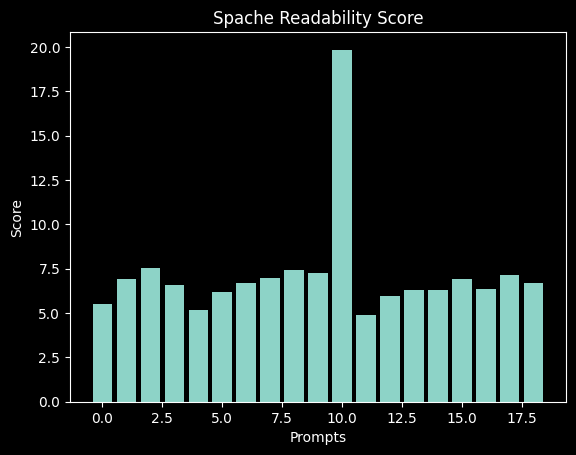

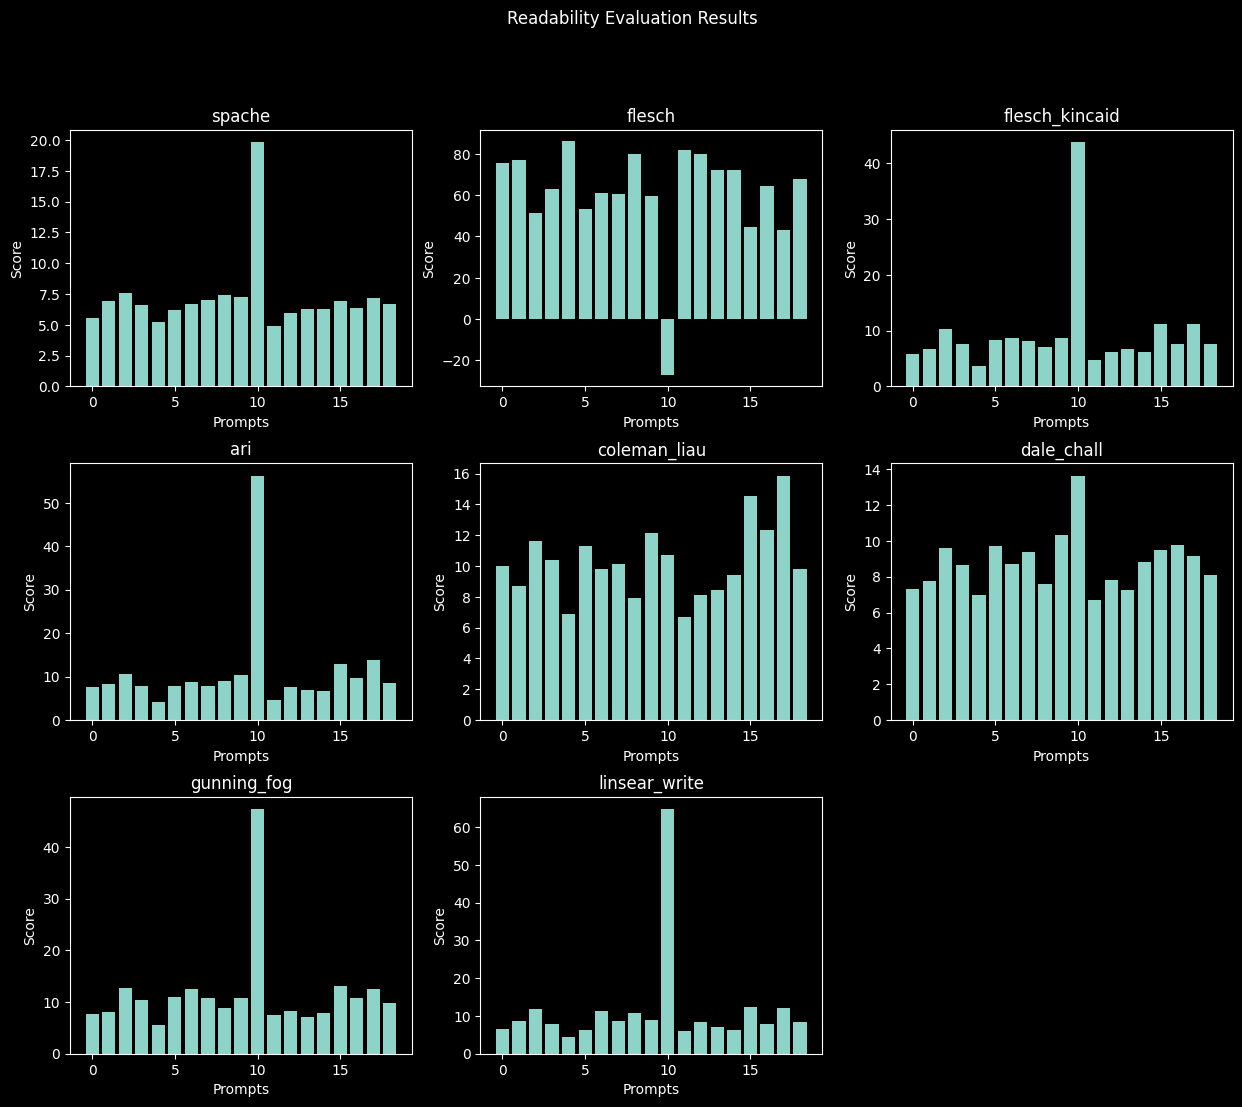

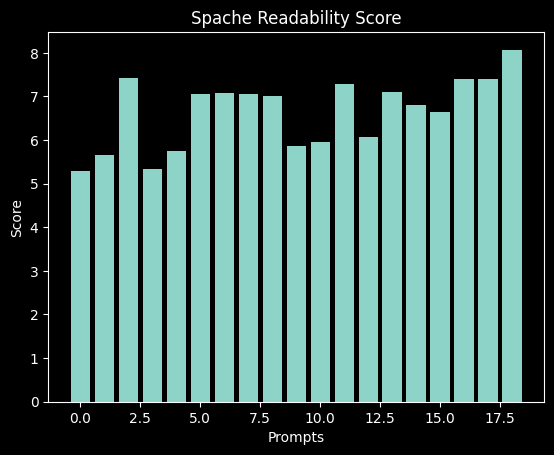

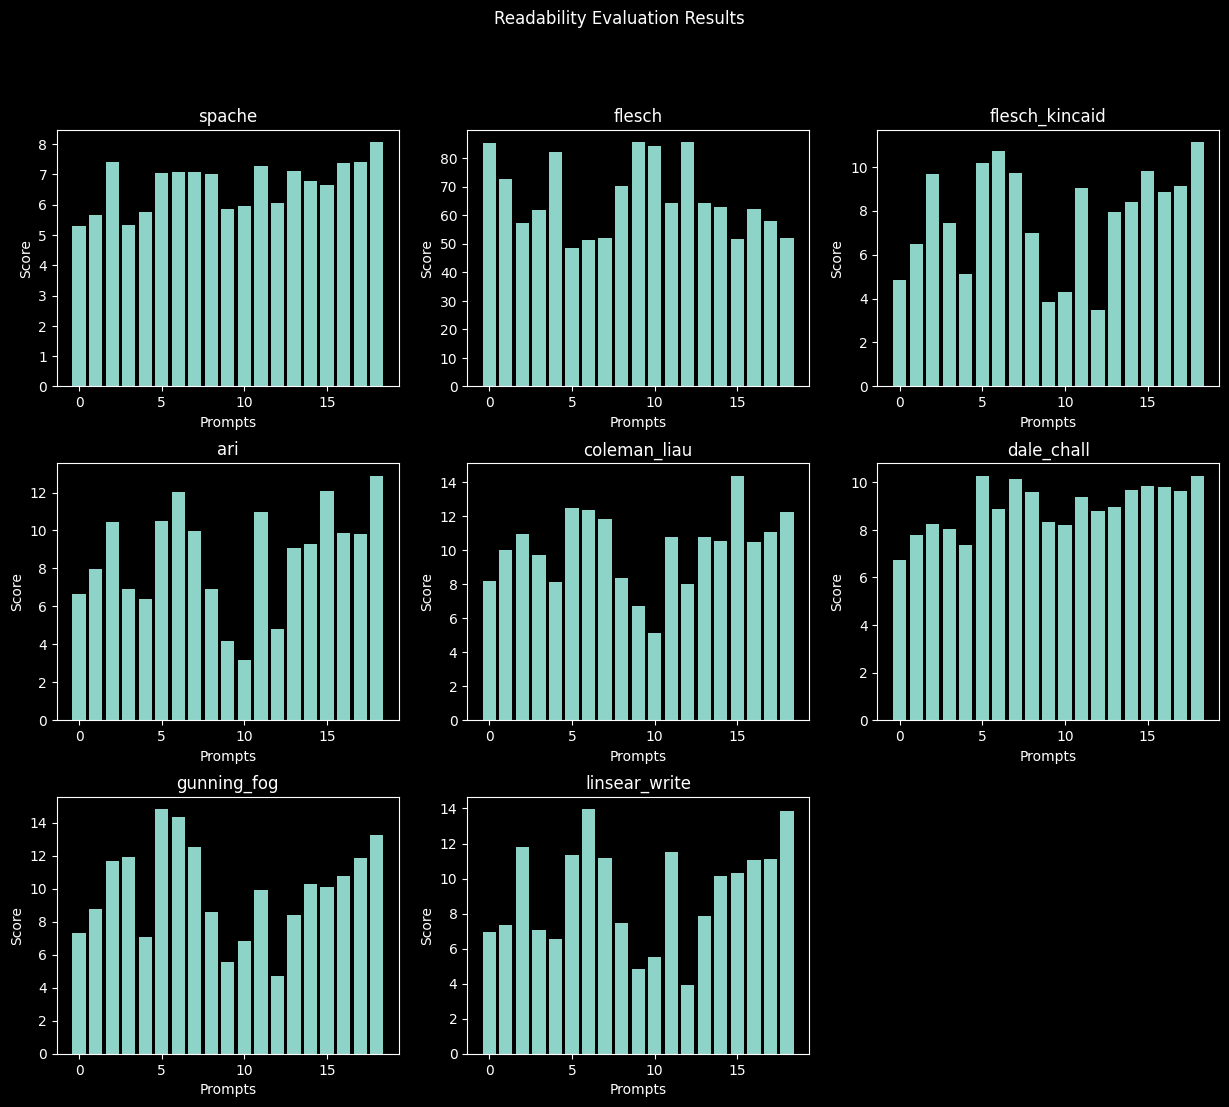

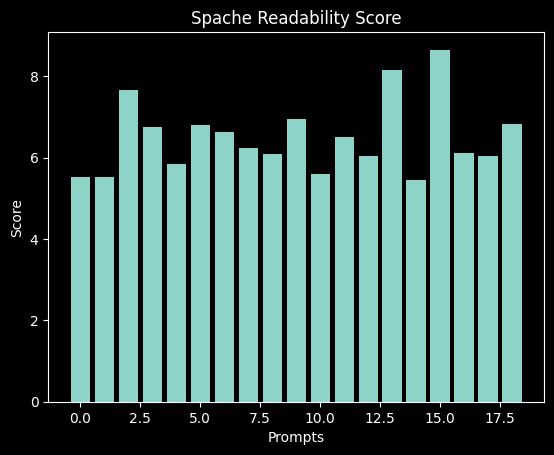

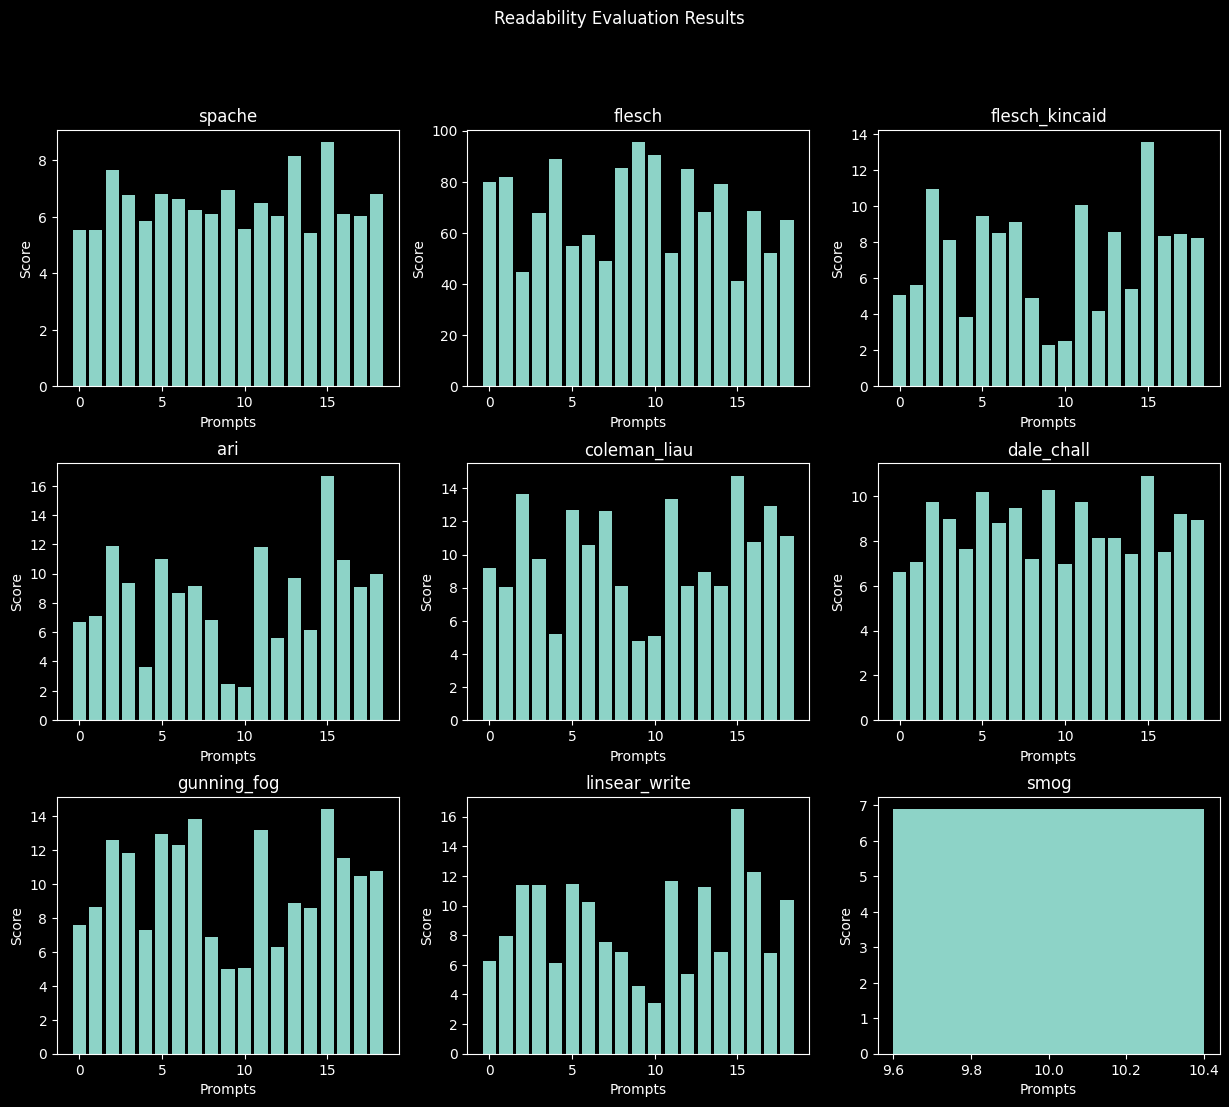

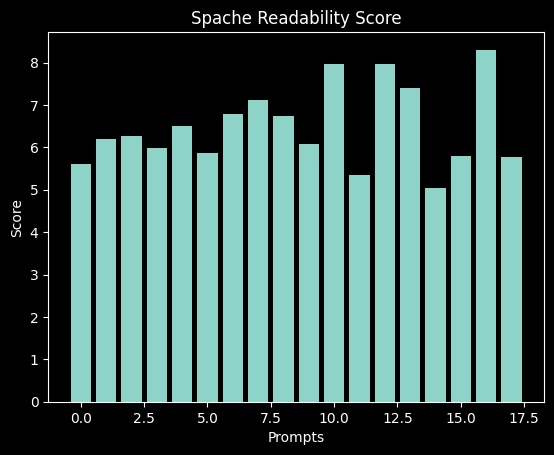

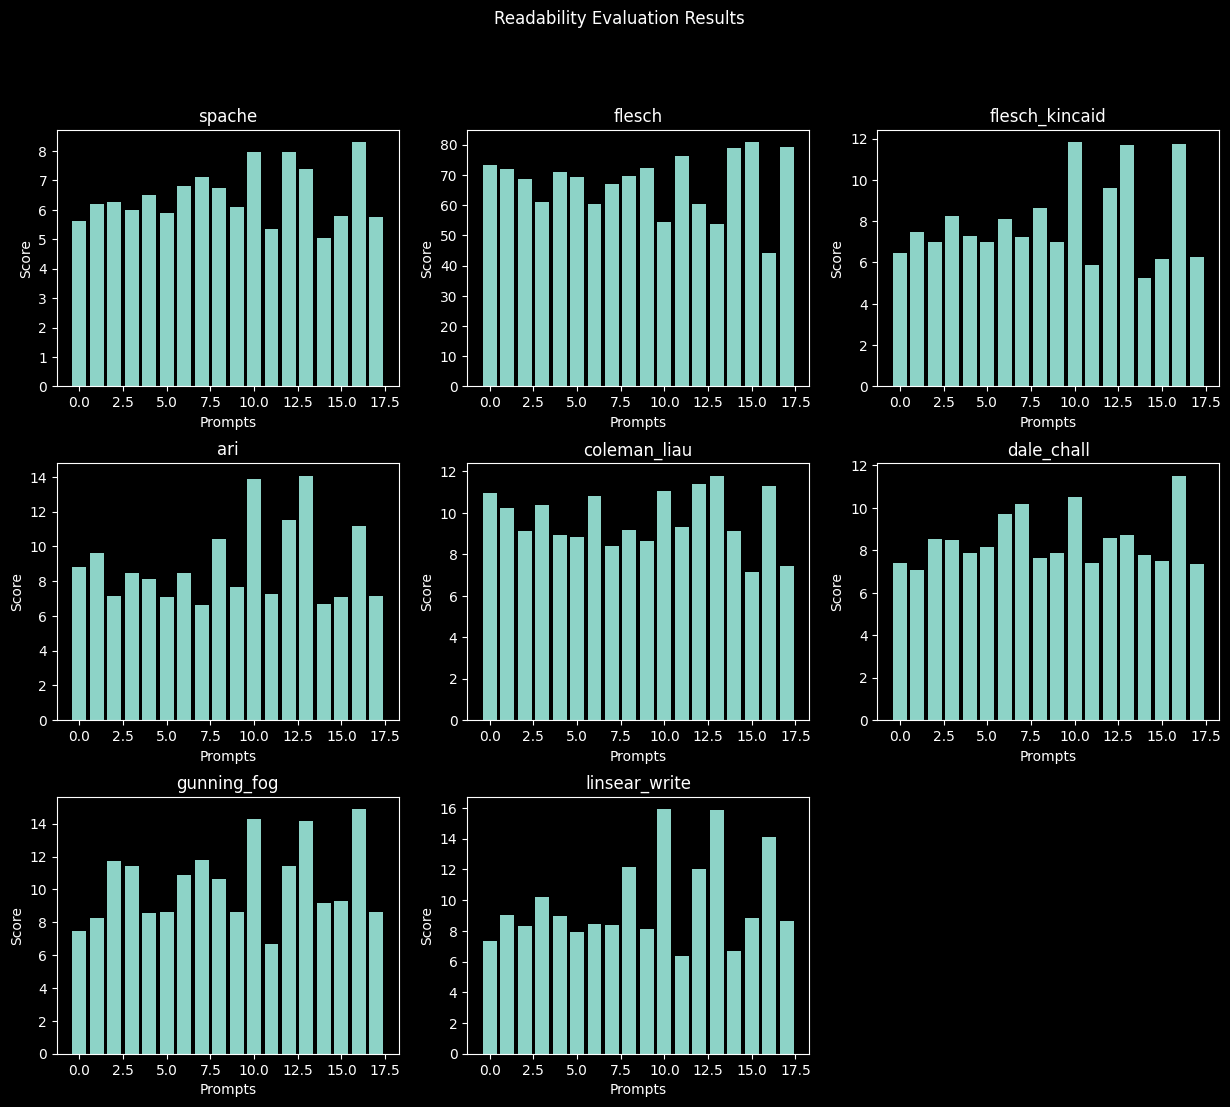

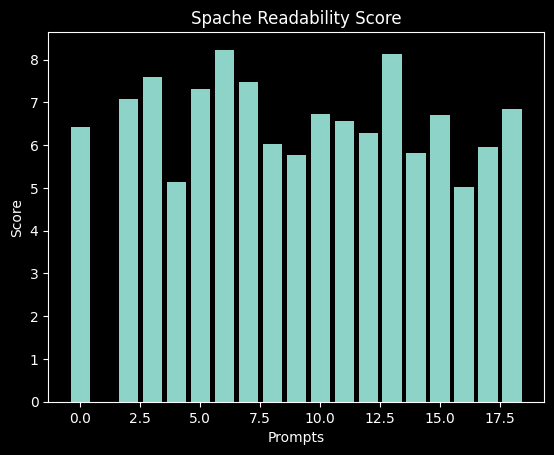

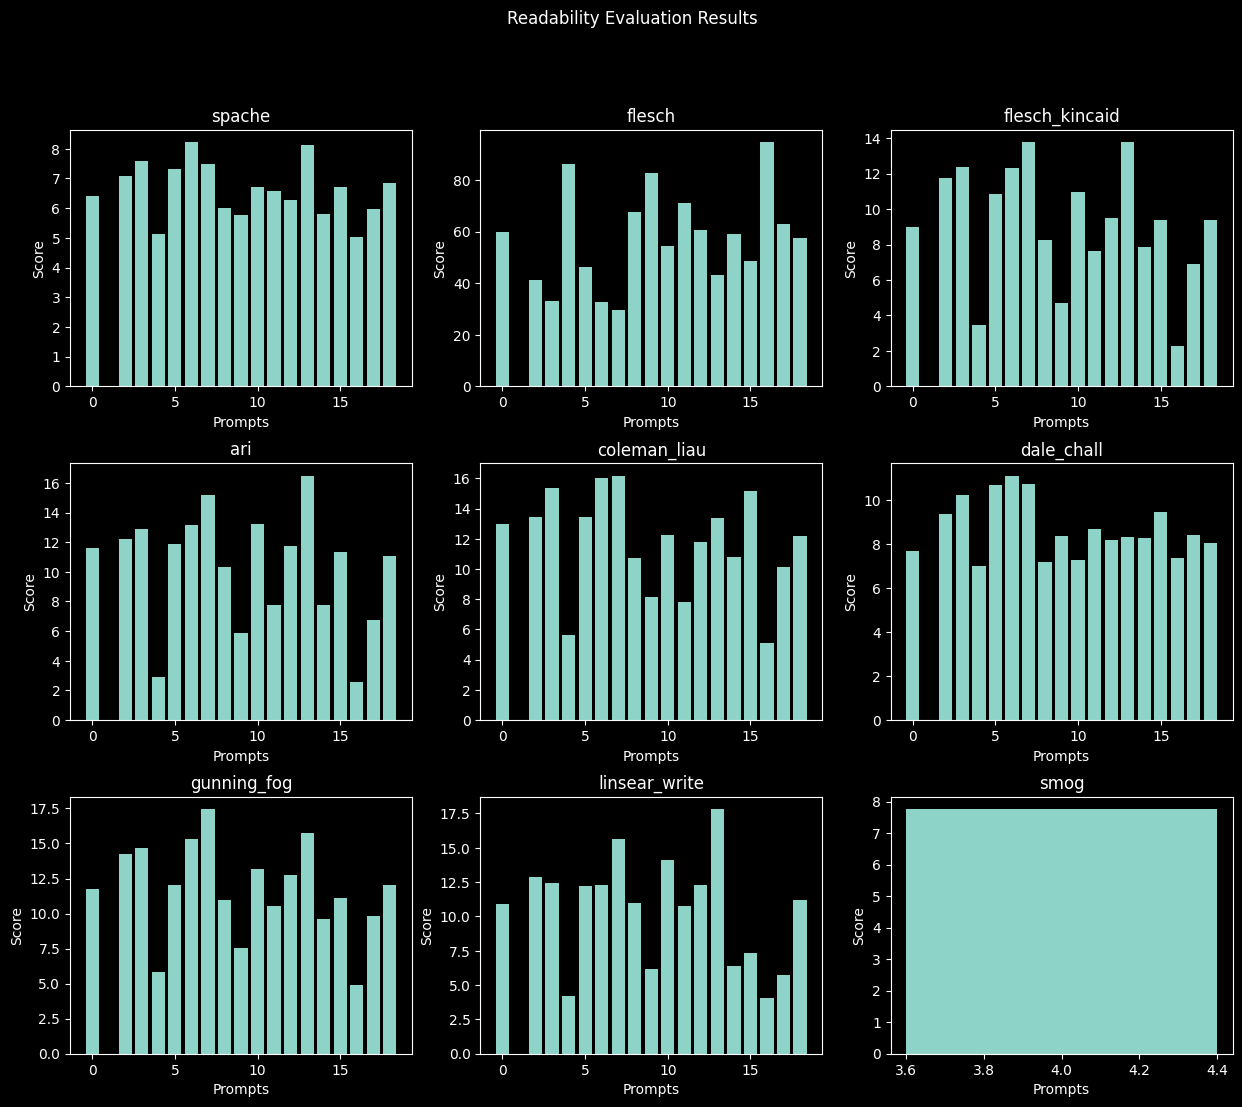

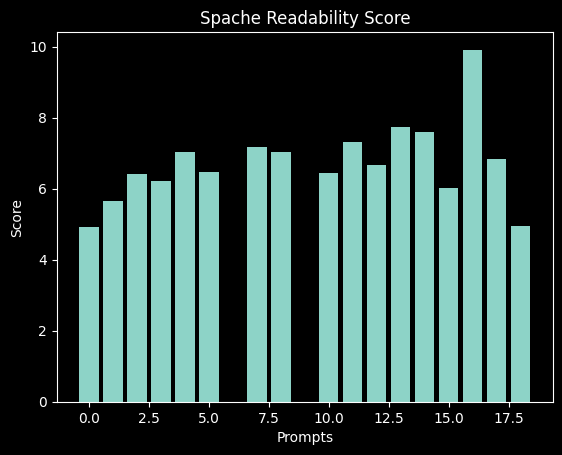

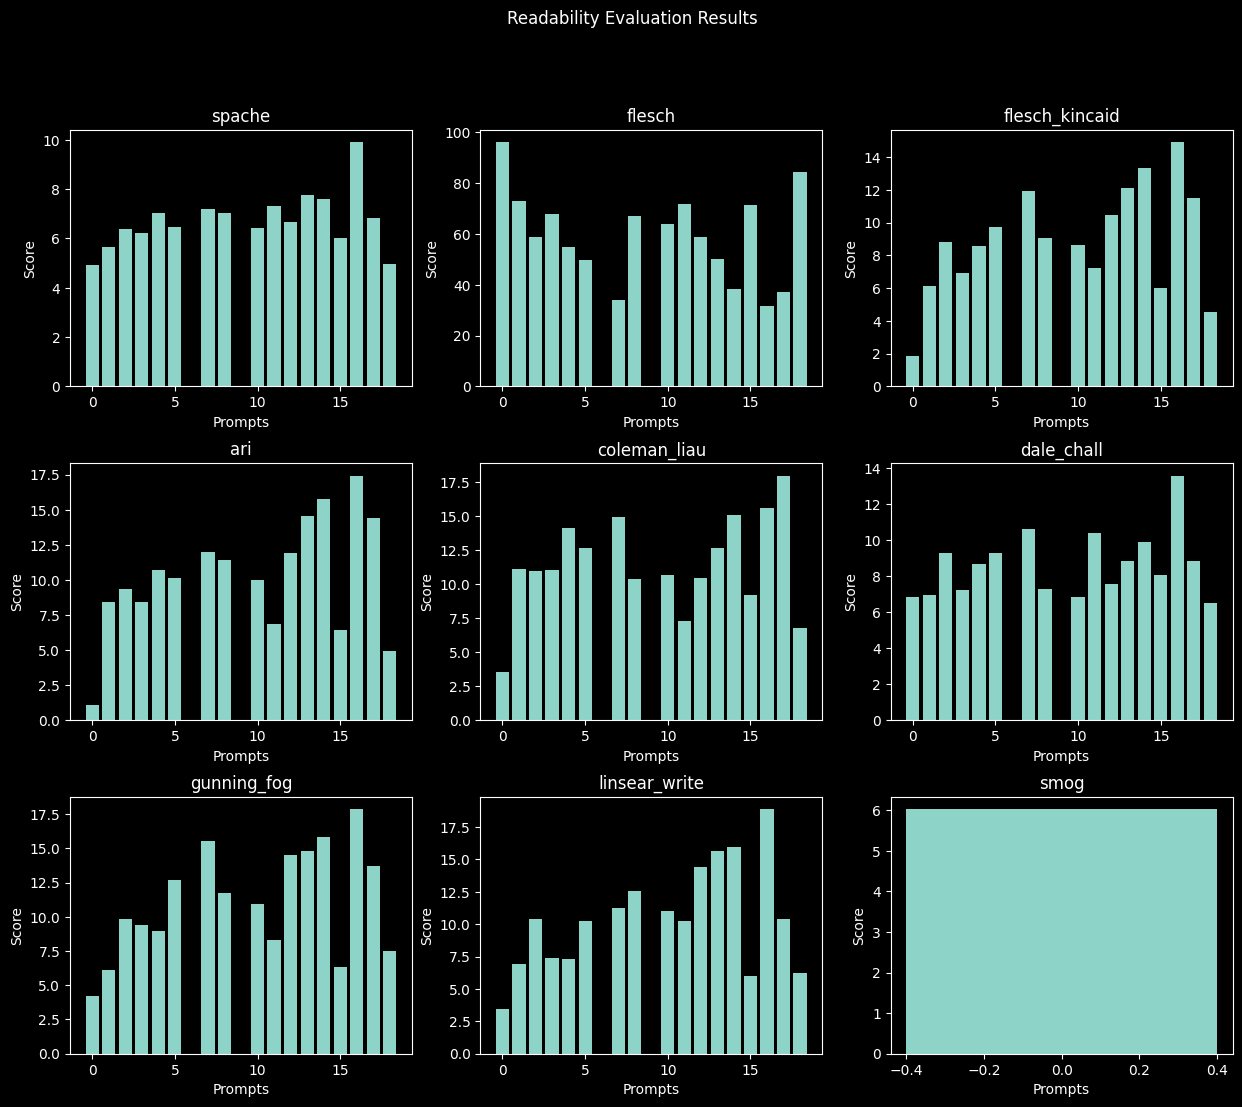

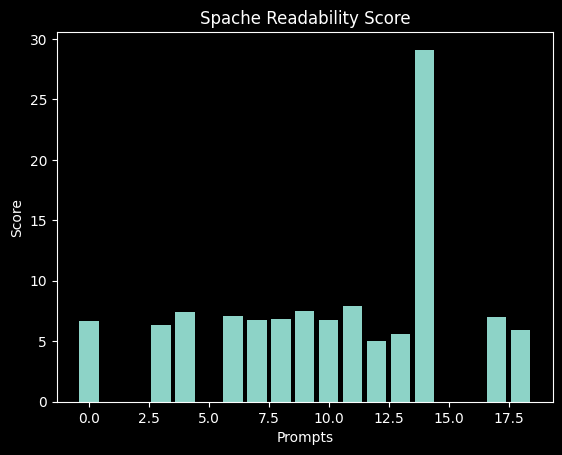

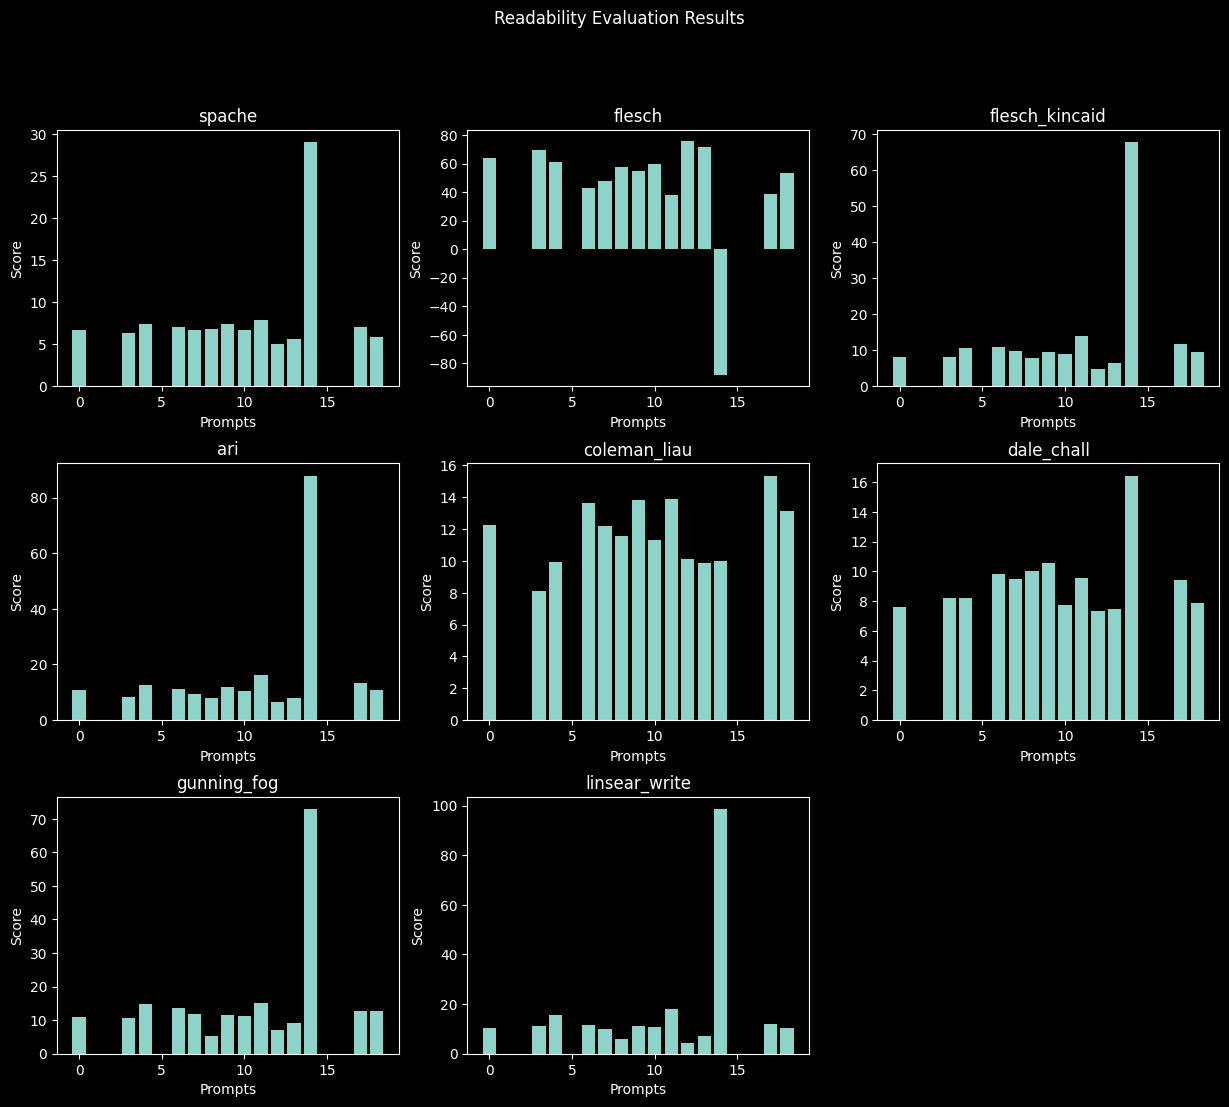

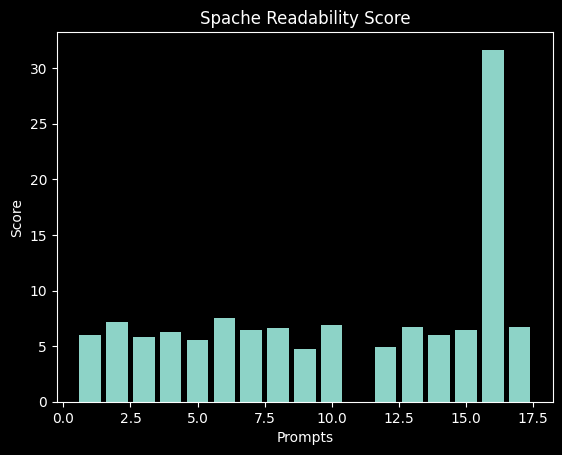

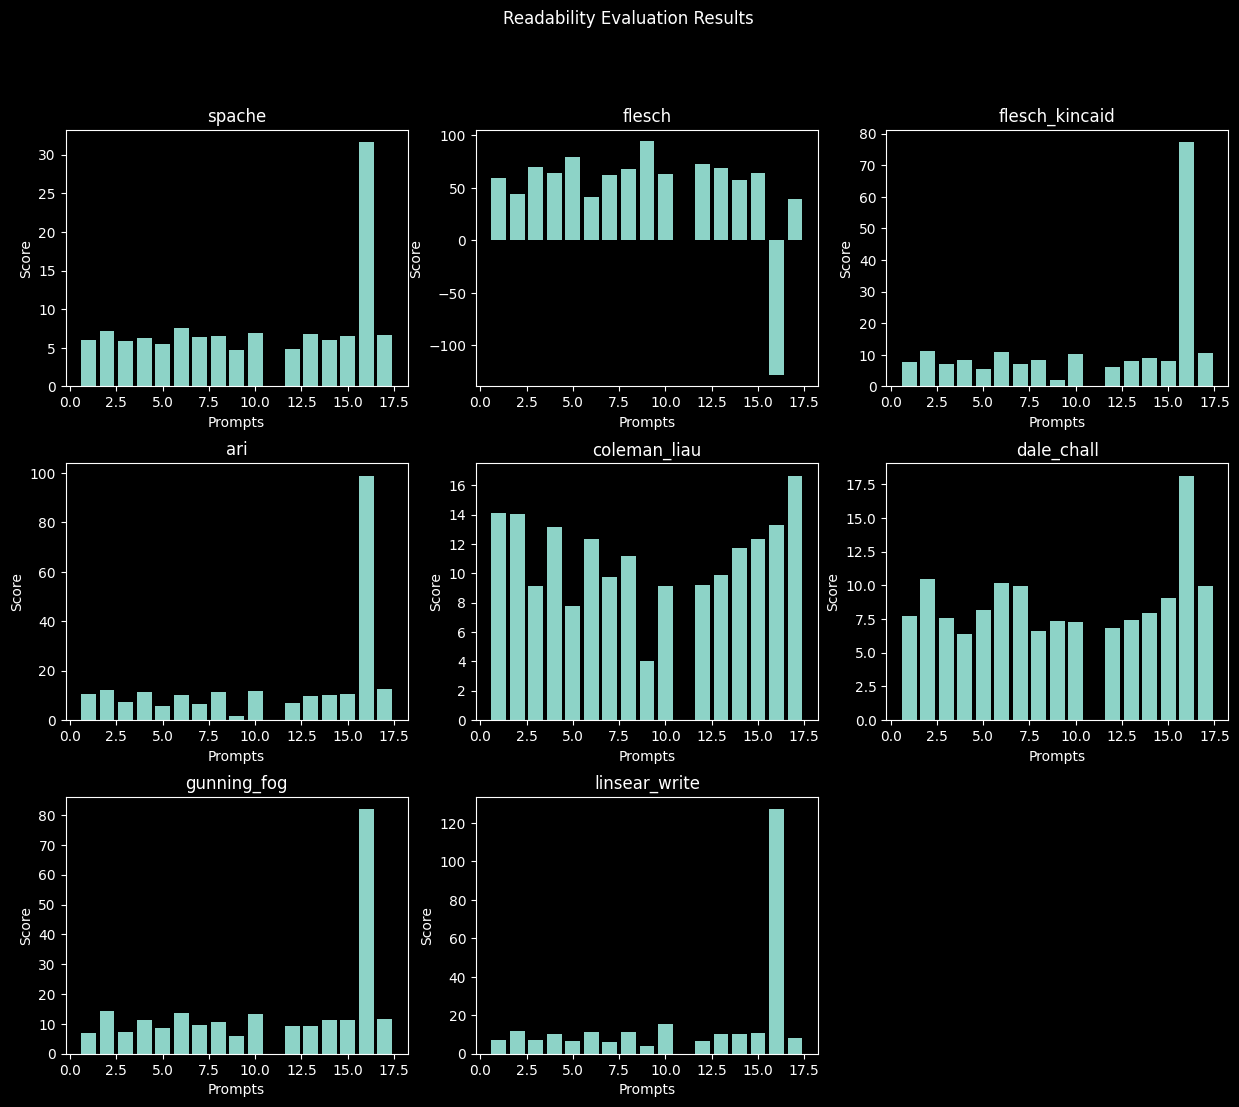

In [12]:
evaluation_william_ds = graph_results("evaluation_william.tsv")
evaluation_sophie_ds= graph_results("evaluation_sophie.tsv")
evaluation_reading_level_10_ds = graph_results("evaluation_reading_level_10.tsv")
evaluation_age_10_ds = graph_results("evaluation_age_10.tsv")

eval_dict = {
    "William": evaluation_william_ds,
    "Sophie": evaluation_sophie_ds,
    "Reading level 10": evaluation_reading_level_10_ds,
    "Age 10": evaluation_age_10_ds
}


evaluation_william_ds_mistral = graph_results("evaluation_william_mistral.tsv")
evaluation_sophie_ds_mistral = graph_results("evaluation_sophie_mistral.tsv")
evaluation_reading_level_10_ds_mistral = graph_results("evaluation_reading_level_10_mistral.tsv")
evaluation_age_10_ds_mistral = graph_results("evaluation_age_10_mistral.tsv")


eval_dict_mistral = {
    "William": evaluation_william_ds_mistral,
    "Sophie": evaluation_sophie_ds_mistral,
    "Reading level 10": evaluation_reading_level_10_ds_mistral,
    "Age 10": evaluation_age_10_ds_mistral
}

In [13]:
# Source: https://stackoverflow.com/a/60270421
def bar_plot(ax, data, colors=None, total_width=0.8, single_width=1, legend=True):
    """Draws a bar plot with multiple bars per data point.

    Parameters
    ----------
    ax : matplotlib.pyplot.axis
        The axis we want to draw our plot on.

    data: dictionary
        A dictionary containing the data we want to plot. Keys are the names of the
        data, the items is a list of the values.

        Example:
        data = {
            "x":[1,2,3],
            "y":[1,2,3],
            "z":[1,2,3],
        }

    colors : array-like, optional
        A list of colors which are used for the bars. If None, the colors
        will be the standard matplotlib color cyle. (default: None)

    total_width : float, optional, default: 0.8
        The width of a bar group. 0.8 means that 80% of the x-axis is covered
        by bars and 20% will be spaces between the bars.

    single_width: float, optional, default: 1
        The relative width of a single bar within a group. 1 means the bars
        will touch eachother within a group, values less than 1 will make
        these bars thinner.

    legend: bool, optional, default: True
        If this is set to true, a legend will be added to the axis.
    """

    # Check if colors where provided, otherwhise use the default color cycle
    if colors is None:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    # Number of bars per group
    n_bars = len(data)

    # The width of a single bar
    bar_width = total_width / n_bars

    # List containing handles for the drawn bars, used for the legend
    bars = []

    # Iterate over all data
    for i, (name, values) in enumerate(data.items()):
        # The offset in x direction of that bar
        x_offset = (i - n_bars / 2) * bar_width + bar_width / 2

        # Draw a bar for every value of that type
        for x, y in enumerate(values):
            bar = ax.bar(x + x_offset, y, width=bar_width * single_width, color=colors[i % len(colors)])

        # Add a handle to the last drawn bar, which we'll need for the legend
        bars.append(bar[0])

    # Draw legend if we need
    if legend:
        ax.legend(bars, data.keys())

Text(0, 0.5, 'Readability Score')

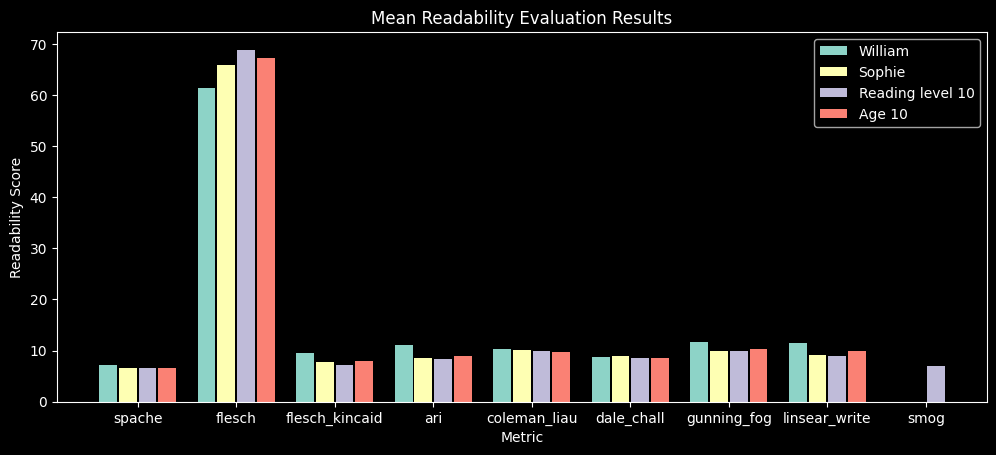

In [31]:
fig, ax = plt.subplots()

plt.title("Mean Readability Evaluation Results")

fig.set_figwidth(12)

mean_scores = {}
for index, (name, ds) in enumerate(eval_dict.items()):
    for i, evaluator in enumerate(readability_evaluators):
        if evaluator not in ds.columns:
            continue
        if name not in mean_scores.keys():
            mean_scores[name] = []
        mean_scores[name].append((ds[evaluator].mean()))

bar_plot(ax, mean_scores, total_width=.8, single_width=.9)

plt.xticks(range(len(readability_evaluators)), readability_evaluators)

plt.xlabel("Metric")
plt.ylabel("Readability Score")

Text(0, 0.5, 'Readability Scores')

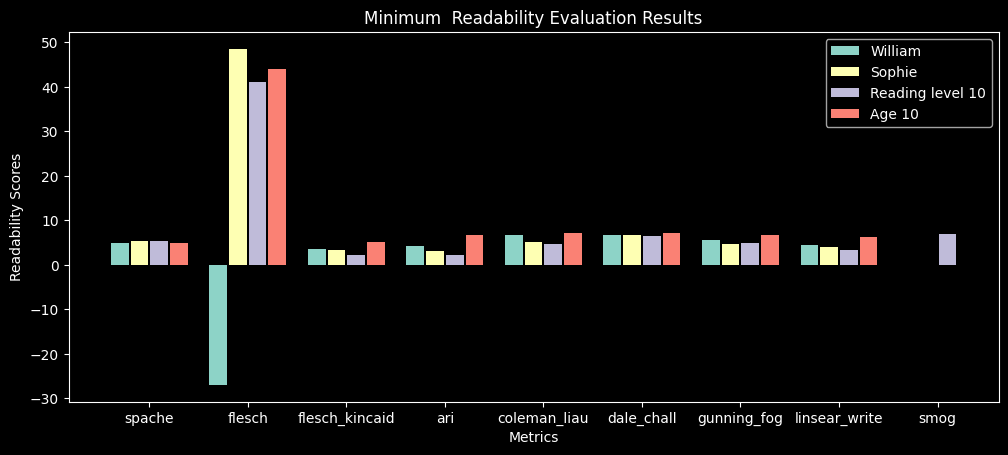

In [32]:
fig, ax = plt.subplots()

plt.title("Minimum  Readability Evaluation Results")

fig.set_figwidth(12)

mean_scores = {}
for index, (name, ds) in enumerate(eval_dict.items()):
    for i, evaluator in enumerate(readability_evaluators):
        if evaluator not in ds.columns:
            continue
        if name not in mean_scores.keys():
            mean_scores[name] = []
        mean_scores[name].append((ds[evaluator].min()))

bar_plot(ax, mean_scores, total_width=.8, single_width=.9)

plt.xticks(range(len(readability_evaluators)), readability_evaluators)

plt.xlabel("Metrics")
plt.ylabel("Readability Scores")

Text(0, 0.5, 'Readability Scores')

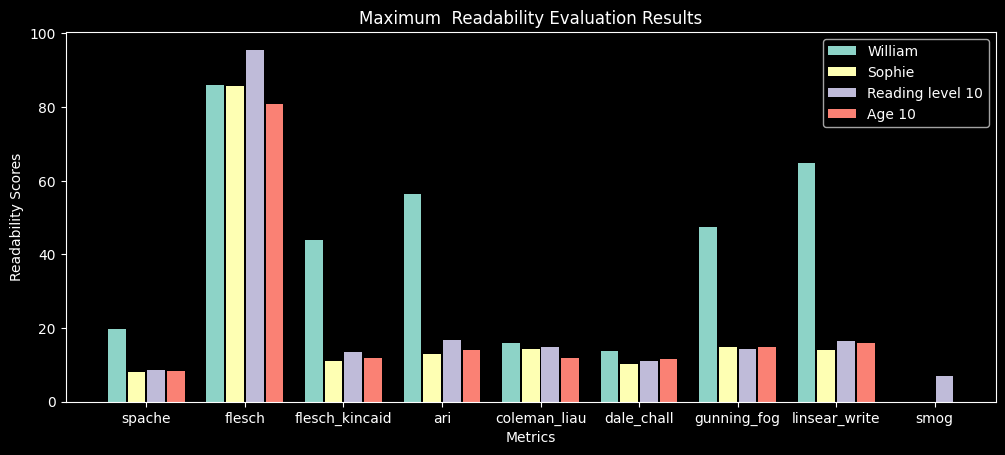

In [33]:
fig, ax = plt.subplots()

plt.title("Maximum  Readability Evaluation Results")

fig.set_figwidth(12)

mean_scores = {}
for index, (name, ds) in enumerate(eval_dict.items()):
    for i, evaluator in enumerate(readability_evaluators):
        if evaluator not in ds.columns:
            continue
        if name not in mean_scores.keys():
            mean_scores[name] = []
        mean_scores[name].append((ds[evaluator].max()))

bar_plot(ax, mean_scores, total_width=.8, single_width=.9)

plt.xticks(range(len(readability_evaluators)), readability_evaluators)

plt.xlabel("Metrics")
plt.ylabel("Readability Scores")

In [ ]:
fig, ax = plt.subplots()

plt.title("Maximum  Readability Evaluation Results")

fig.set_figwidth(12)

mean_scores = {}
for index, (name, ds) in enumerate(eval_dict.items()):
    for i, evaluator in enumerate(readability_evaluators):
        if evaluator not in ds.columns:
            continue
        if name not in mean_scores.keys():
            mean_scores[name] = []
        mean_scores[name].append((ds[evaluator].max()))

bar_plot(ax, mean_scores, total_width=.8, single_width=.9)

plt.xticks(range(len(readability_evaluators)), readability_evaluators)

plt.xlabel("Metrics")
plt.ylabel("Readability Scores")

In [ ]:
for evaluator in readability_evaluators:
    if evaluator not in ds.columns:
        continue
    desc = ds[evaluator].describe()
    print(f"{evaluator}\t{desc['max']:.2f}\t{desc['min']:.2f}\t{desc['std']:.2f}\t{desc['mean']:.2f}")

spache	19.84	4.90	3.15	7.19
flesch	86.05	-26.92	24.76	61.35
flesch_kincaid	43.84	3.67	8.55	9.47
ari	56.26	4.15	11.20	11.01
coleman_liau	15.87	6.66	2.38	10.25
dale_chall	13.64	6.69	1.59	8.78
gunning_fog	47.31	5.55	8.89	11.72
linsear_write	64.75	4.48	13.08	11.52


Text(0, 0.5, 'Readability Score')

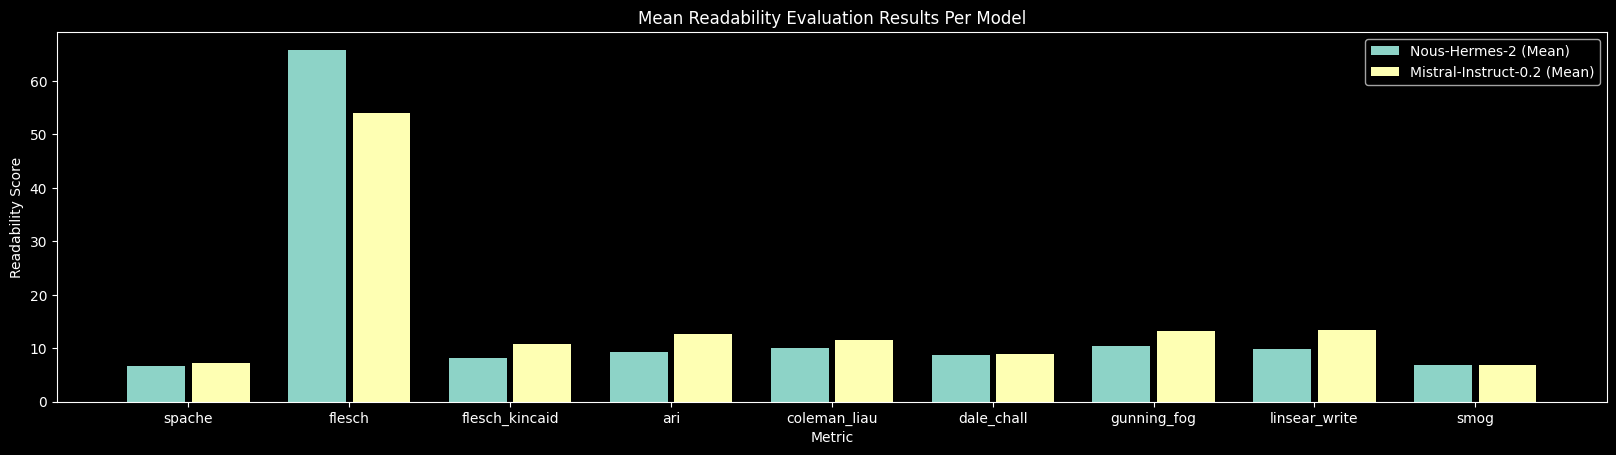

In [22]:
fig, ax = plt.subplots()

plt.title("Mean Readability Evaluation Results Per Model")

fig.set_figwidth(20)
        
nous_ds = pd.concat(eval_dict.values())
mistral_ds = pd.concat(eval_dict_mistral.values())

mean_scores = {
    "Nous-Hermes-2 (Mean)": [],
    "Mistral-Instruct-0.2 (Mean)": []
}

for i, evaluator in enumerate(readability_evaluators):
    if evaluator not in nous_ds.columns:
        continue
    mean_scores["Nous-Hermes-2 (Mean)"].append((nous_ds[evaluator].mean()))
    mean_scores["Mistral-Instruct-0.2 (Mean)"].append((mistral_ds[evaluator].mean()))

bar_plot(ax, mean_scores, total_width=.8, single_width=.9)

plt.xticks(range(len(readability_evaluators)), readability_evaluators)

plt.xlabel("Metric")
plt.ylabel("Readability Score")